# Deep Learning for Predictive Maintenance

This is the skeleton code file for the EEC4400 assignment. Replace the XX in the name of this notebook with your group number (this is important for correct marks to be awarded to your group). Fill in the blank cells below with the necessary code (you should work on this notebook section by section). At the end, the entire notebook should generate all the required results and execute without error.

The text above the blank cells provide some information on the functionality that needs to be implemented. You need to write Python code at places indicated by "[WriteCode]".

In this notebook, we explore the following:

1. CNN 1D and LSTM models
2. Two types of prediction tasks
  
  a. Binary Classification :  determining if a machine will fail in a given "w1" window period (Yes/No)

  b. Regression : predicting the remaining time a machine can run before failing (RUL)


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras # make sure you use TensorFlow Keras
import seaborn as sns
import warnings
import os
import time
%matplotlib inline

from sklearn import preprocessing

# Extra imports must be done by students
# [WriteCode] from ... import ...
# [WriteCode] from ... import ...
# [WriteCode] from ... import ...

# Setting seed for reproducibility (uncomment and use if needed)
# np.random.seed(xx)  
# PYTHONHASHSEED = x

## Setting up TensorBoard

In [2]:
def get_run_logdir(k):
  root_logdir = os.path.join(os.curdir, "eec4400_logs", k)
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

## Initialize model parameters

Use the form below to enter parameter values before re-running the notebook. 

Use the same no. of epochs (ep) and batch size (ba) values for all the baseline CNN-Bin, LSTM-Bin, CNN-RUL and LSTM-RUL models.

Create additional variables and fields in this form as you require.

In [3]:
# Input Parameters
sequence_length = 25 # length of each sequence of values
ep =  10 # epochs
ba =  100 # batch_size                 

In [4]:
# DO NOT CHANGE the settings in this cell
w1 = 30 # window size before failure classification

## Data Ingestion
In the following section, 
- We ingest the training, test and ground truth datasets
- We provide column headings for consistency

(*Note*: training, test and ground truth dataframes are named "train_df", "test_df", and "truth_df" correspondingly. This naming is used consistently throughout the skeleton file.)

In [5]:
# Data ingestion

# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# final Training data
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Exploration

Understanding the underlying characteristics of the dataset:
- Plot cross-correlation heatmap to understand correlation between sensor readings in training data (use seaborn package)
- Observe the data characteristics of three machines with shortest, average and longest operating lifetime (code provided)

(*Note*: use the results to answer the Data Exploration question Section 7 of the assignment document)

### Cross-correlation Heatmap

Expected result:

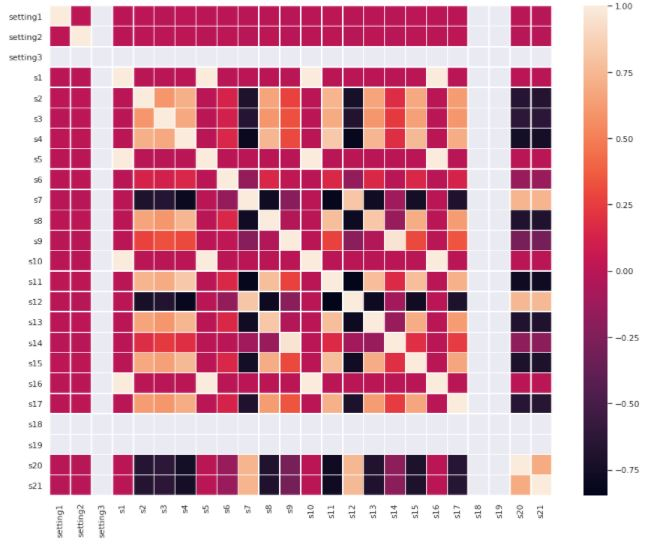

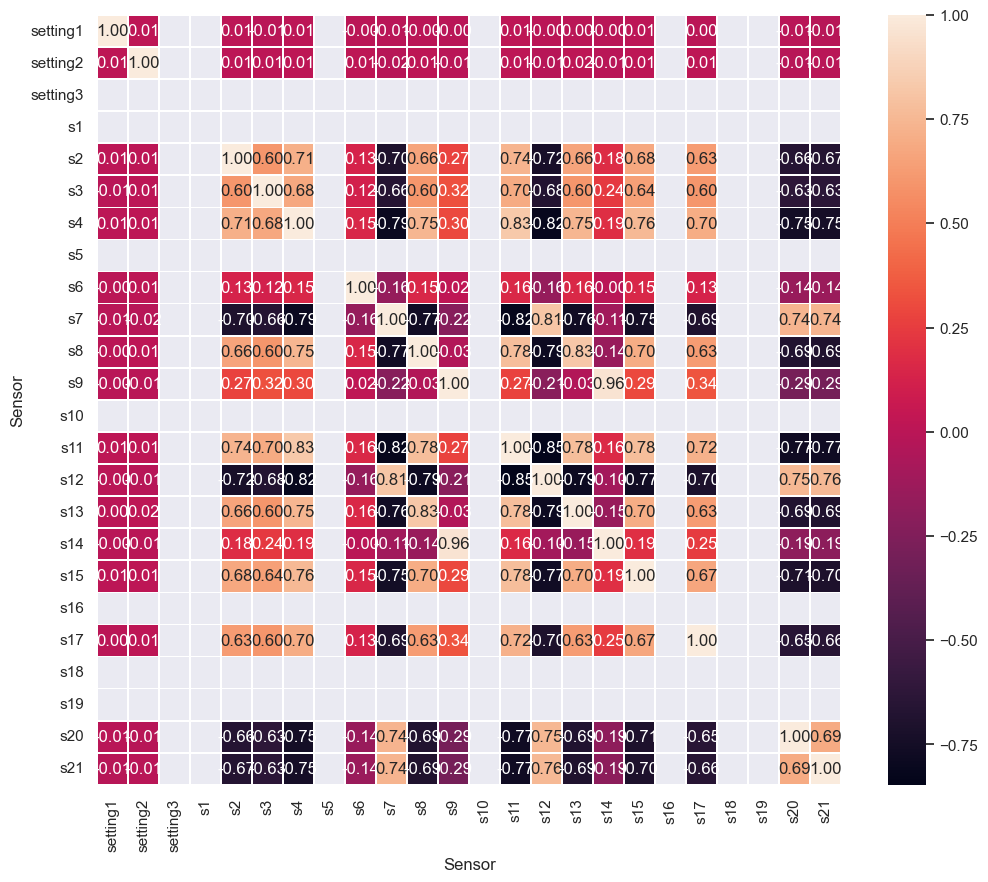

In [6]:
# Cross-correlation HeatMap

sns.set() 
def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)

df_sub = train_df.copy()
del df_sub['id']

df_sub.set_index('cycle', inplace=True)

# [WriteCode] to determine Pearson correlation and save in dataframe df_corr
df_corr = df_sub.corr(method='pearson')

# [WriteCode] for plotting cross-correlation heatmap using seaborn
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df_corr, annot=True, fmt=".2f", linewidths=0.5)
labels("Sensor", "Sensor", heatmap.axes)  # 添加x和y标签
plt.show()

### Shortest, Average and Longest machine lifetimes

In [7]:
# Some Plotting Functions

mapp = {}
for id_num in train_df['id'].unique():
    mapp[id_num] = train_df['cycle'].loc[train_df['id'] == id_num].max()
mapp_len = sorted(mapp.items(), key=lambda kv: kv[1])
wind_size = w1

def exclude_trivial(df_sub):
    cols = []
    for col in df_sub.columns:
        if col == 'id':
            continue
        elif col == 'RUL':
            continue
        elif len(df_sub[col].unique()) <= 2:
            continue
        else:
            cols.append(col)
    return df_sub[cols].copy()

def get_data_non_trivial(df, unit_num, ):
    df_sub = df.loc[df['id'] == unit_num].copy()
    df_sub.set_index('cycle', inplace=True)
    df_sub.dropna(axis=1, how='all', inplace=True)
    df_sub = exclude_trivial(df_sub)
    return df_sub

def get_data_by_cols_and_unit(df, unit_num, cols):
    df_sub = df.loc[df['id'] == unit_num].copy()
    df_sub.set_index('cycle', inplace=True)
    df_sub.dropna(axis=1, how='all', inplace=True)
    df_sub = df_sub[cols]
    return df_sub

def plot_ts(df, unit_num, wind_size):
    '''plot all non trivial measurements and states'''
    df_sub = get_data_non_trivial(df, unit_num)
    cols = df_sub.columns
    fig, axes = plt.subplots(len(cols), 1, figsize=(15,12))
    for col, ax in zip(cols, axes):
        df_sub[col].plot(ax = ax)
        df_sub[col].rolling(wind_size).median().plot(ax = ax)
        df_sub[col].rolling(wind_size).mean().plot(style = '--', legend=True, ax = ax)
    fig.suptitle('unit NUM: {}'.format(unit_num))

def plot_hist(df, unit_num, wind_size):
    '''plot all non trivial measurements and states'''
    df_sub = get_data_non_trivial(df, unit_num)
    cols = df_sub.columns
    n_cols = min(len(cols), 5)
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,12))
    axes = axes.flatten()
    for col, ax in zip(cols, axes):
        sns.distplot(df_sub[[col]], ax=ax, label=col)
        labels(col, "p", ax)
    fig.suptitle('unit NUM: {}'.format(unit_num))
    
def plot_learn(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.ylim((0, 0.1))
    plt.xlim((1, ep))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

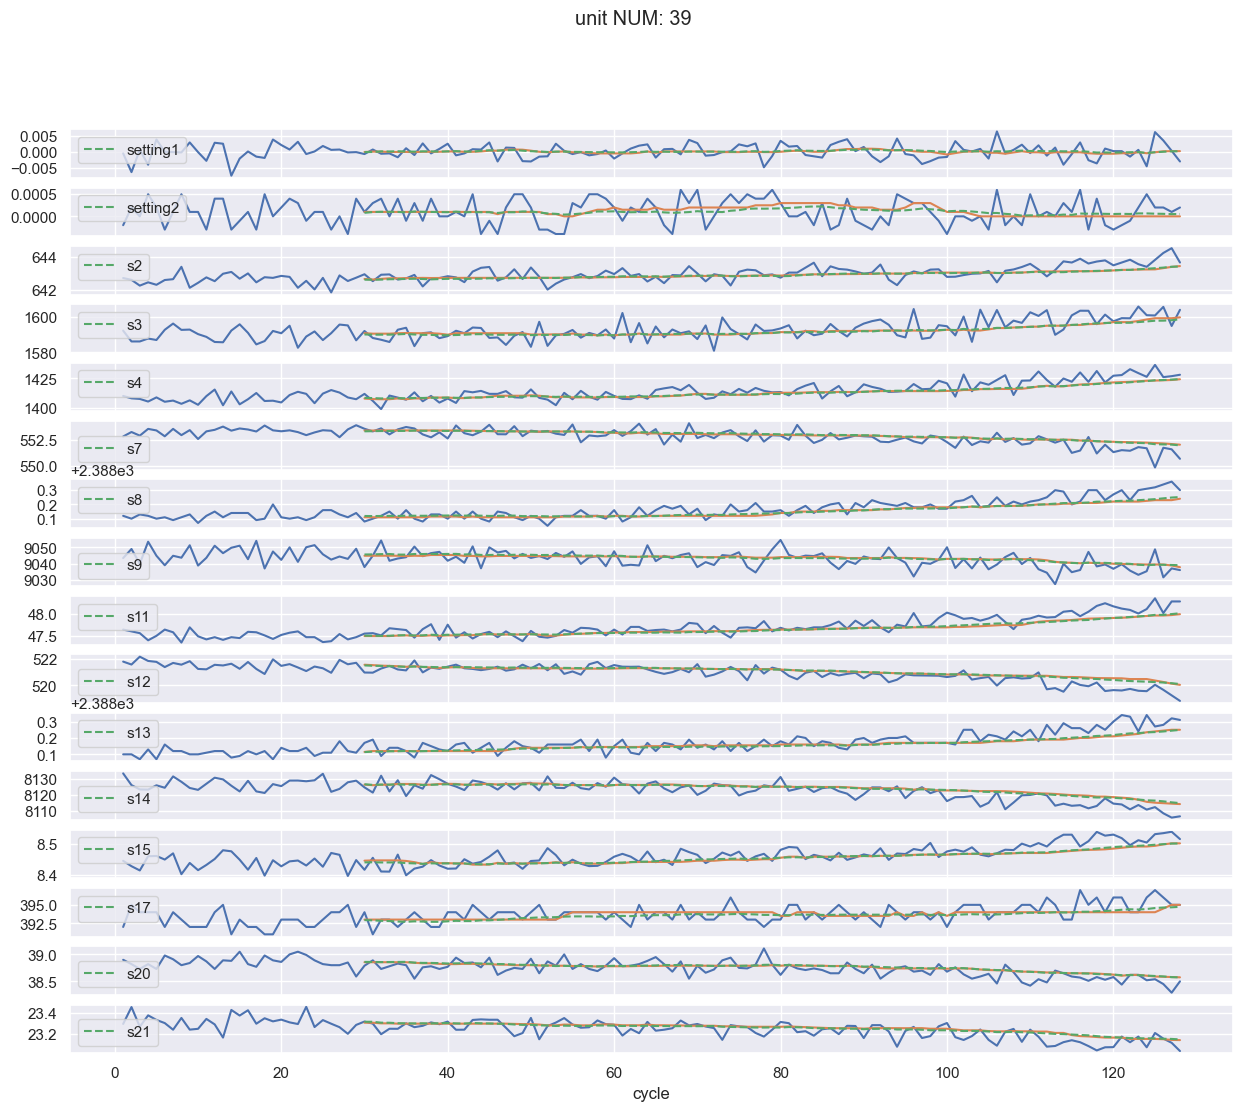

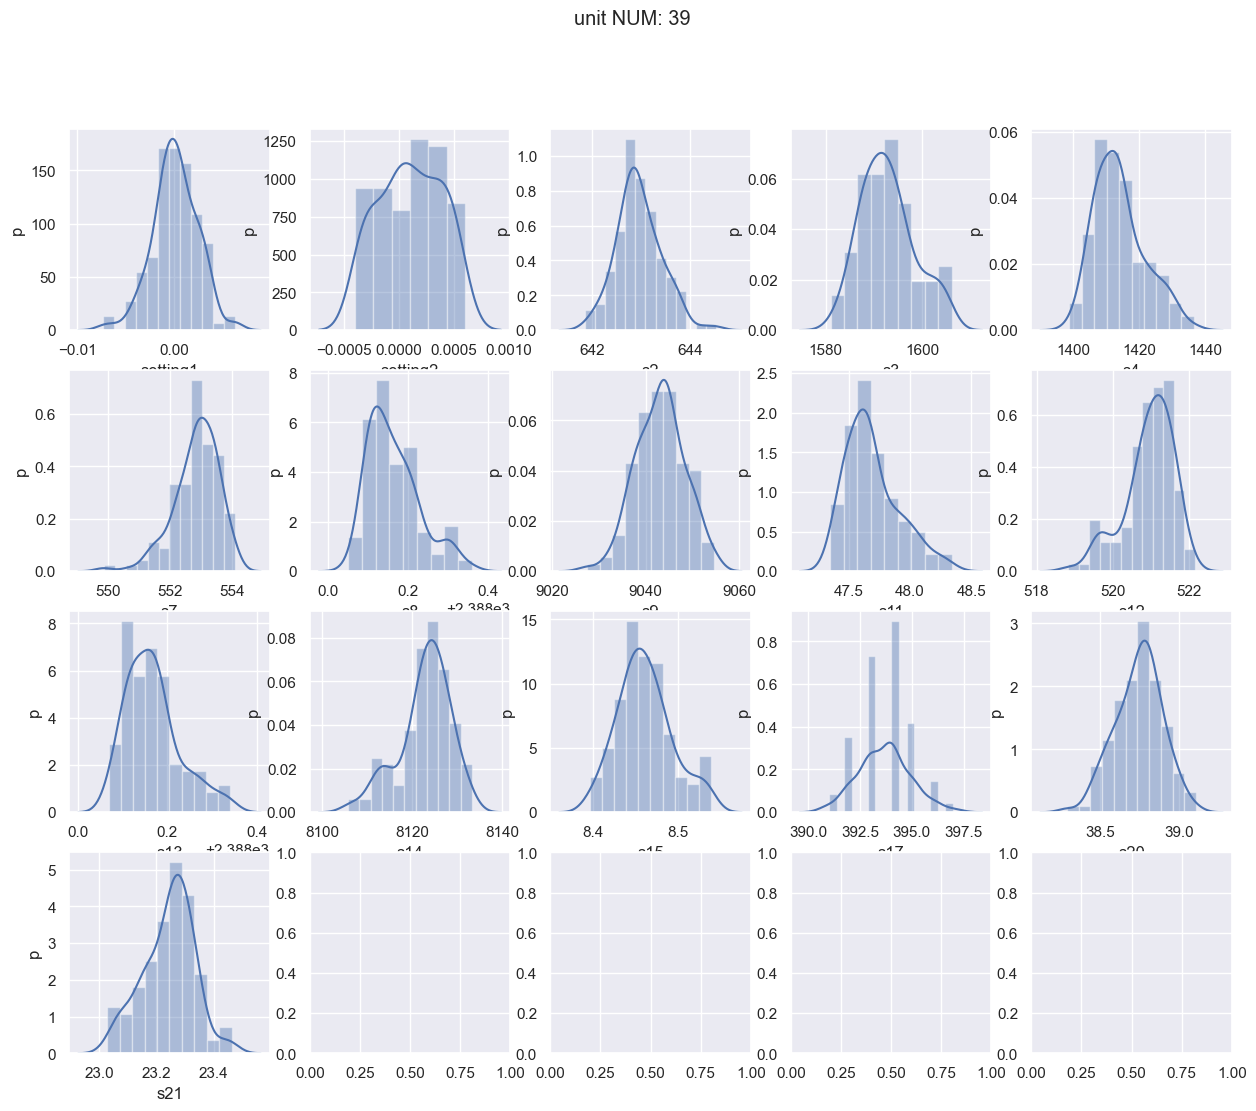

In [8]:
# Plotting sensor readings and distribution of sensor readings for machines with shortest, medium and longest operating times
warnings.filterwarnings('ignore')

# plot shortest operating time machine data
unit_to_plt = mapp_len[0][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

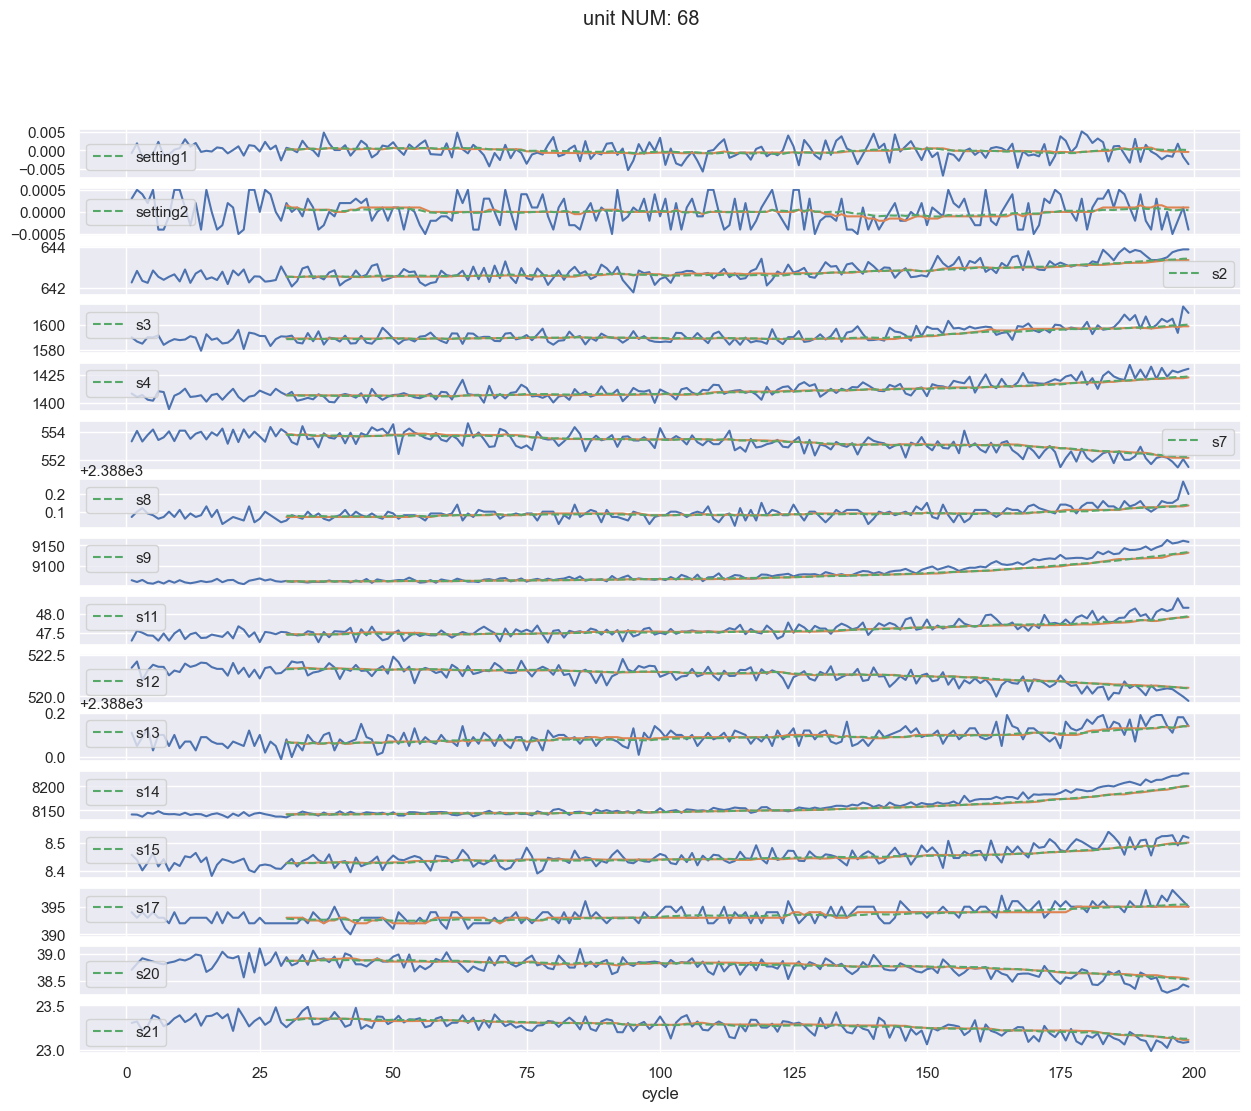

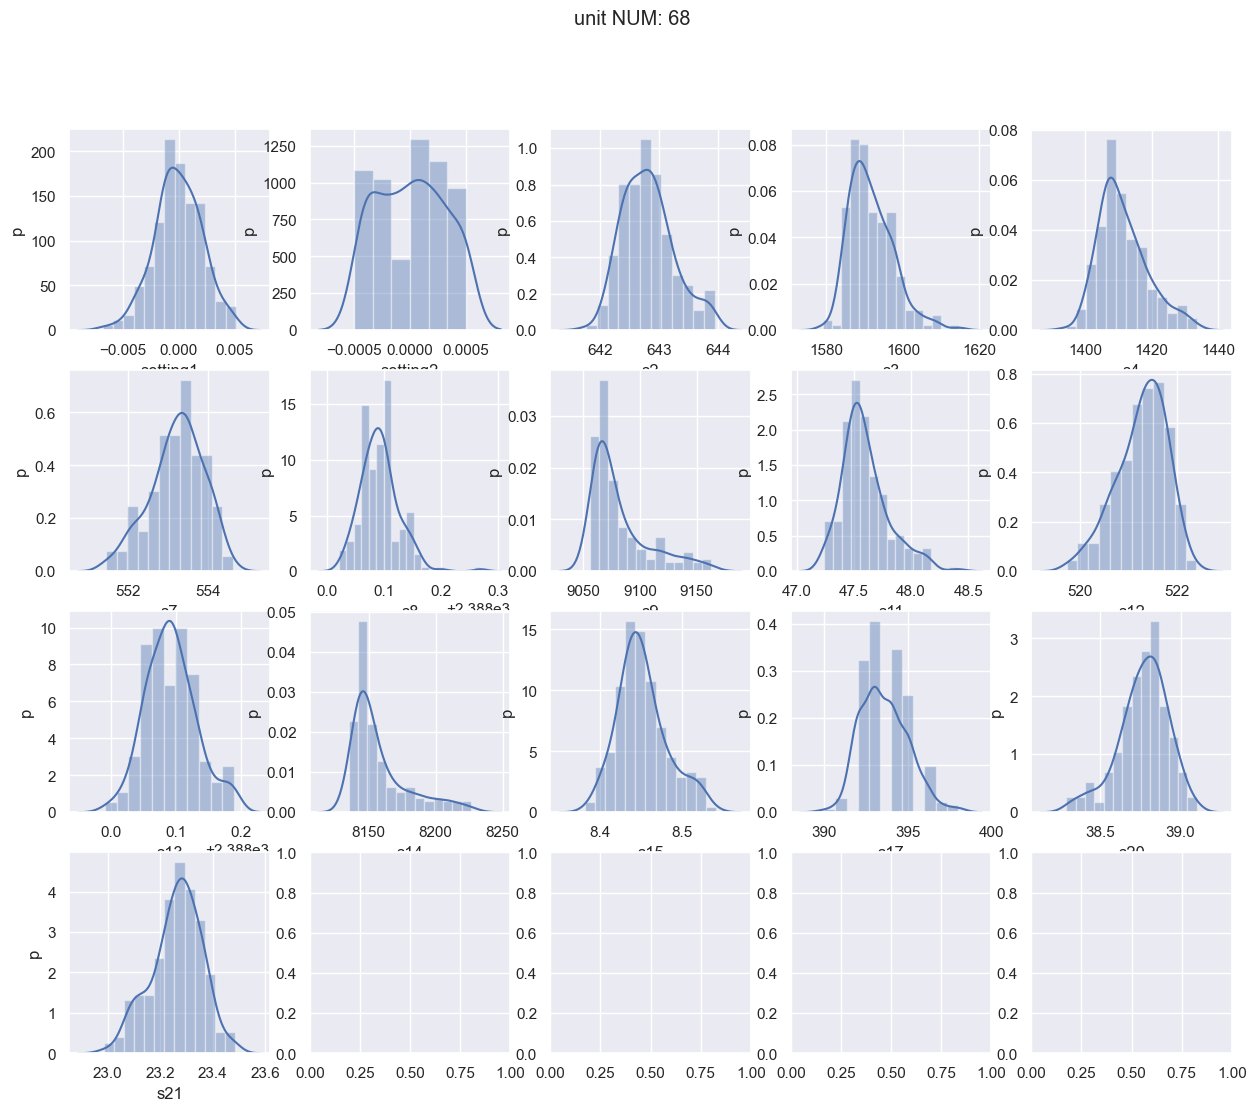

In [9]:
# plot medium operating time machine data
unit_to_plt = mapp_len[int(len(mapp)/2)][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

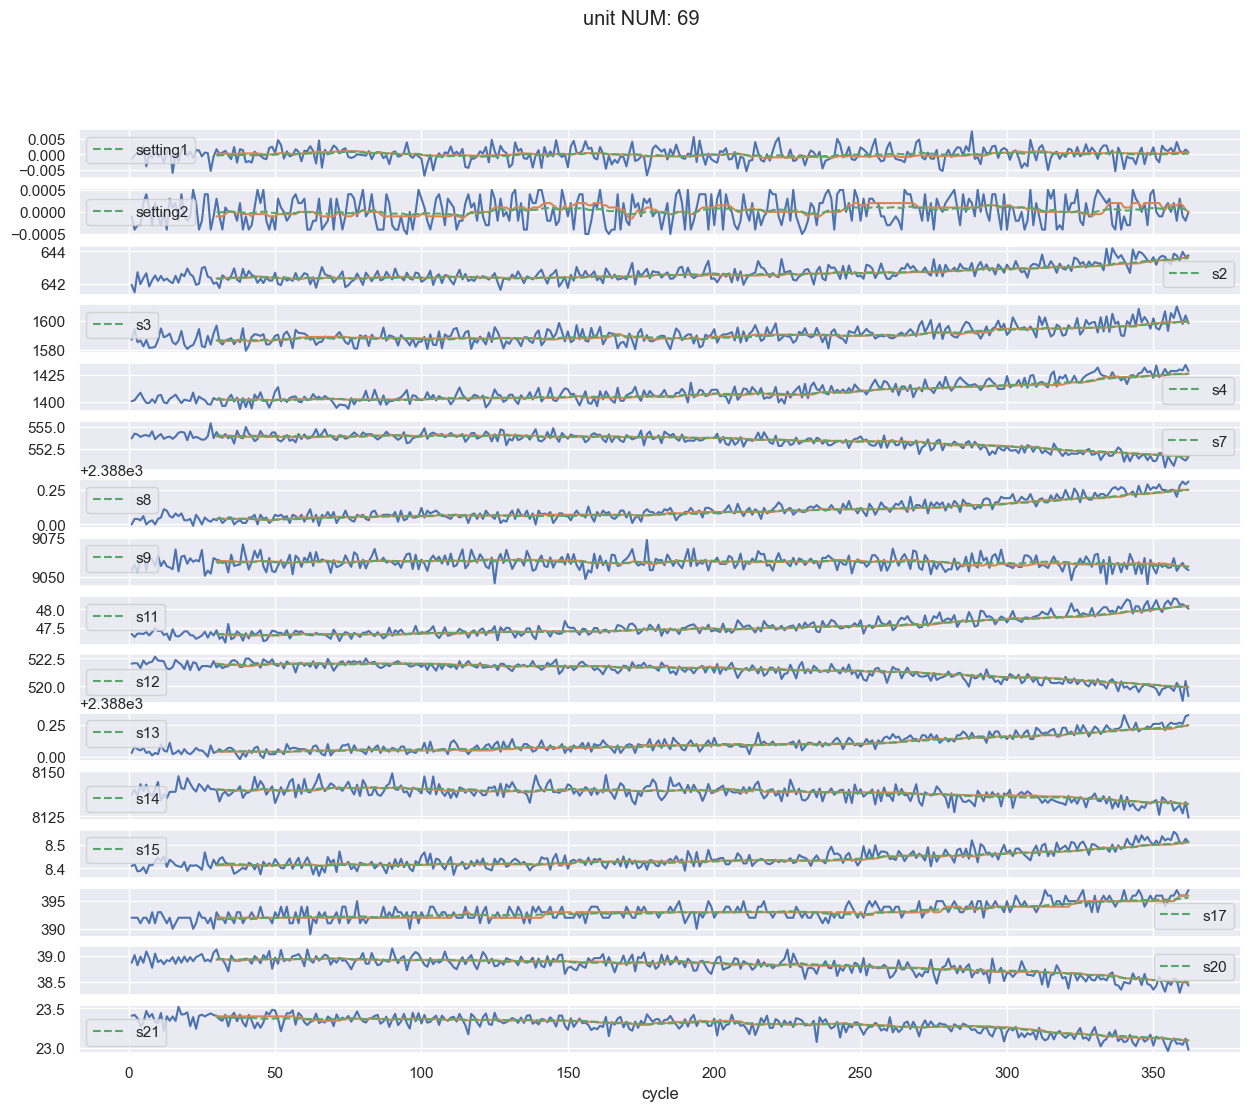

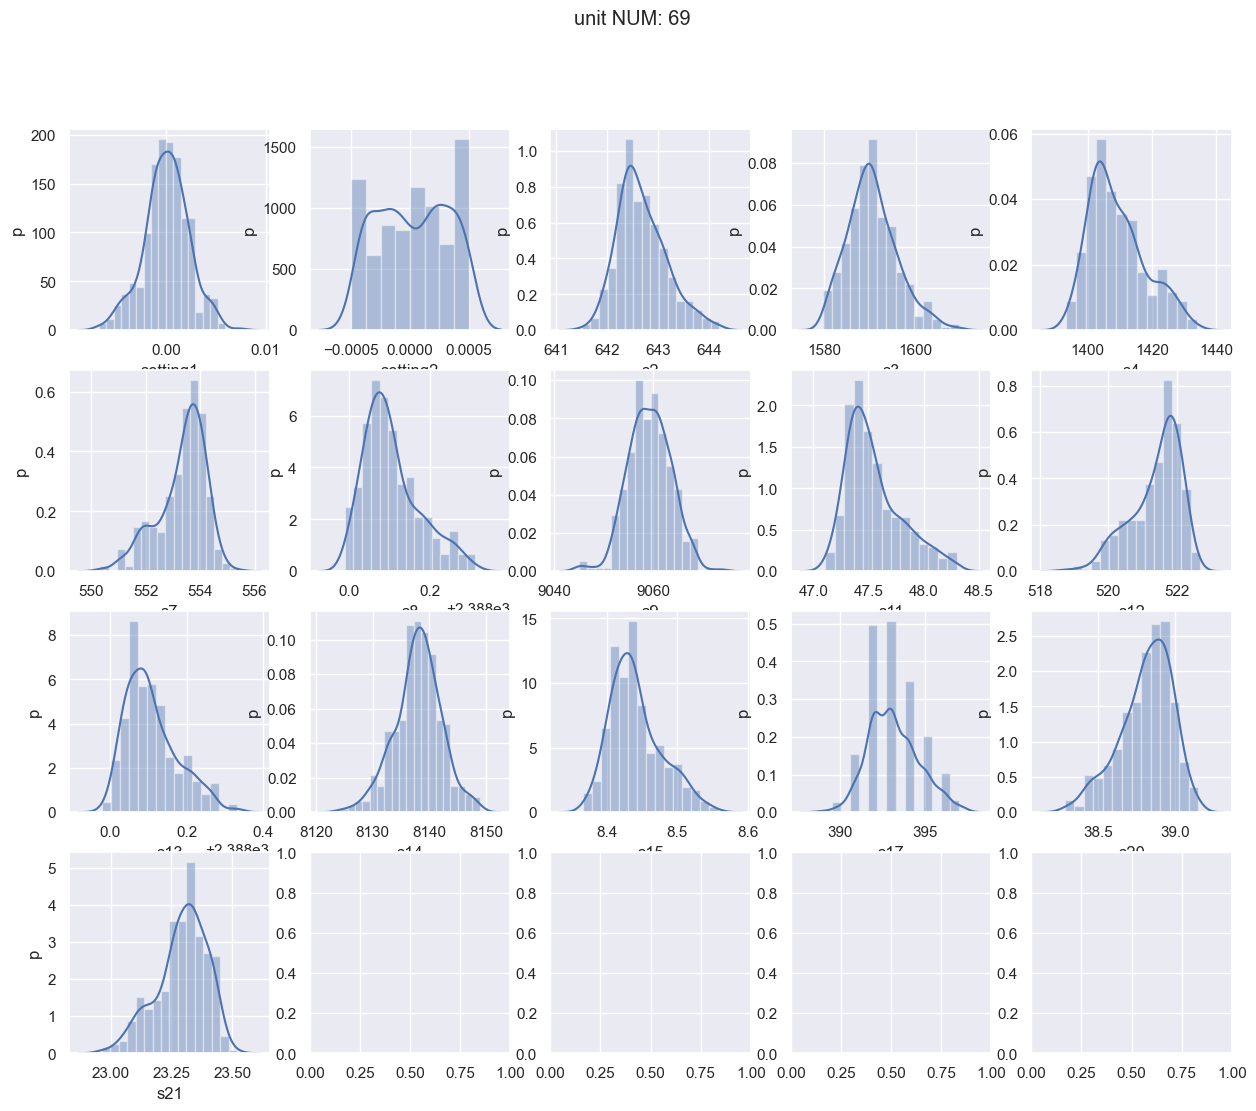

In [10]:
# plot longest operating time machine data
unit_to_plt = mapp_len[-1][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

warnings.filterwarnings('default')

## Data Preprocessing


### Data Labeling

Generating labels for the training data for both prediction tasks:
- Remaining Useful Life ("RUL") for regression task
- "label1" for binary classification (to answer the question: is a specific engine going to fail within "w1" cycles?)

Columns "RUL" and "label1" are created

(*Note*: Column names are case-sensitive and this section is already coded.)

In [11]:
# Data Labeling for training data - generate column RUL

rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label1 column for training data
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [12]:
# Data Labeling for test data - generate column RUL

rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label1 column for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


### Data Normalization

Perform minmax normalization using MinMax scaler in sklearn on both training and test data (train_df and test_df)


In [13]:
# MinMax normalization for training data

train_df['cycle_norm'] = train_df['cycle']
scaler=preprocessing.MinMaxScaler()
cols_to_normalize=['cycle_norm','setting1','setting2','setting3']+[f's{i}' for i in range(1,22)]
# [WriteCode]
train_df[cols_to_normalize]=scaler.fit_transform(train_df[cols_to_normalize])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


In [14]:
# MinMax normalization for test data

test_df['cycle_norm'] = test_df['cycle']

# [WriteCode]
test_df[cols_to_normalize]=scaler.transform(test_df[cols_to_normalize])
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0,0.01108


### Data Plotting

In this section, students must plot training data. Please do the follwing:
- Use only data pertaining to engine id = 3
- Plot only the last "sequence_length" operating cycles for each sensor reading in engine 3 training data (for example: if seq_len = 50, plot the last 50 operating cycles of engine 3). 
- Use separate plot for each column or sensor reading. 

X axis: cycles and Y axis : sensor reading

expected result:
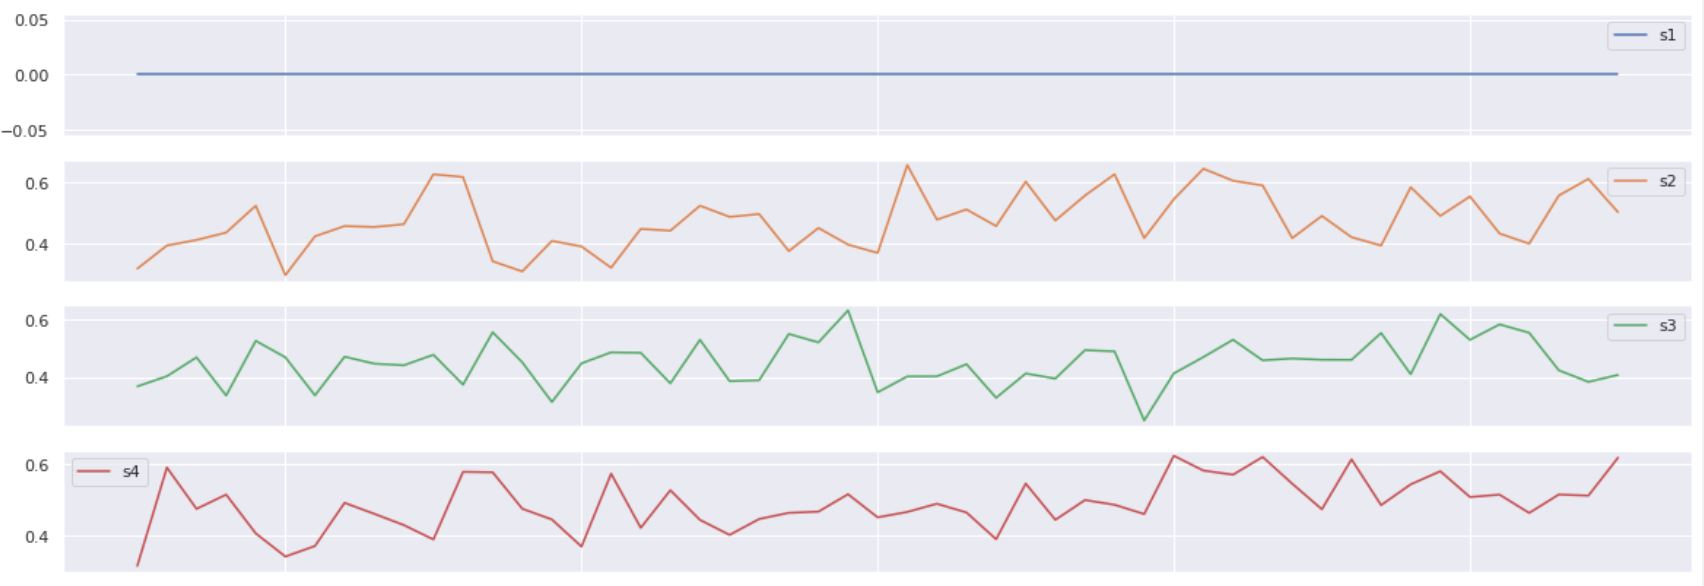

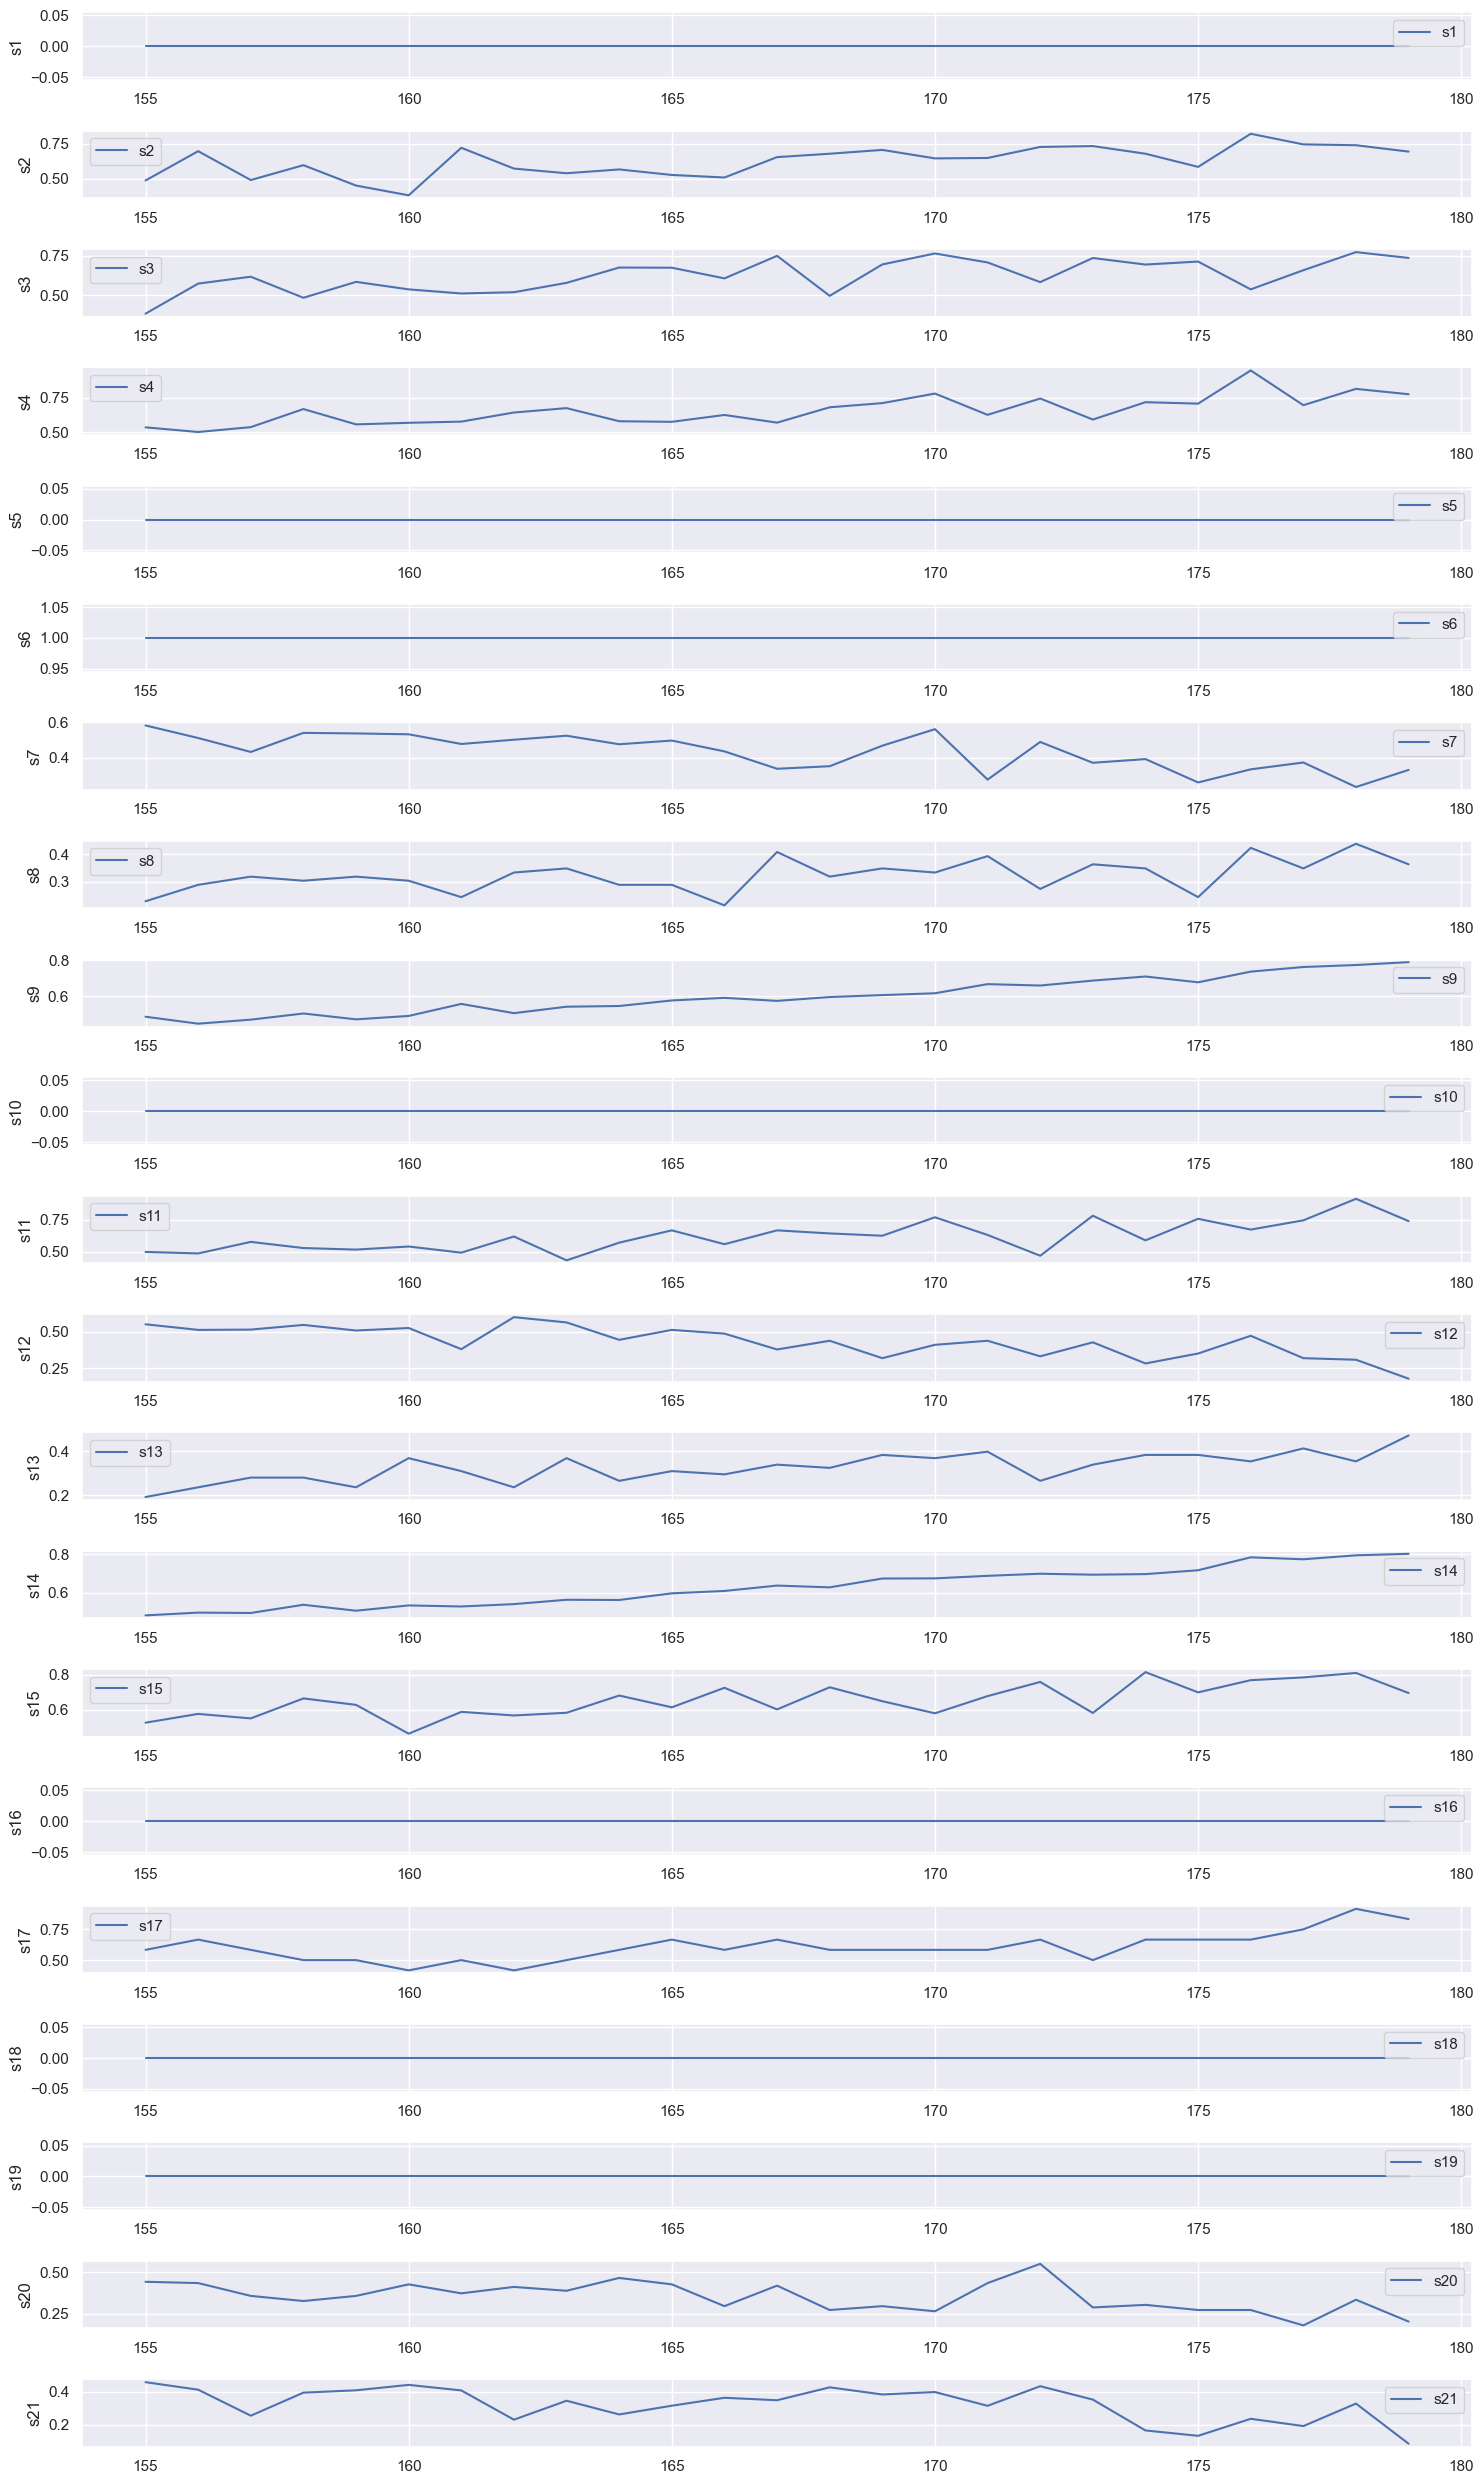

In [16]:
# [WriteCode]
# Filter the data for engine id = 3
engine_3_data = train_df[train_df['id'] == 3]

# Extract only the last `sequence_length` cycles
engine_3_data_last_seq = engine_3_data.iloc[-sequence_length:]

# List of sensor columns to plot
sensor_columns = [f's{i}' for i in range(1, 22)]

# Plot each sensor reading
plt.figure(figsize=(15, 25))  # Adjust the figure size as needed
for i, sensor in enumerate(sensor_columns, 1):
    plt.subplot(len(sensor_columns), 1, i)
    plt.plot(engine_3_data_last_seq['cycle'], engine_3_data_last_seq[sensor], label=sensor)
    plt.ylabel(sensor)
    plt.legend()
    plt.tight_layout()

plt.show()


### Data Sequence Generation

Any deep learning model requires two data arrays for model training. The first array is the input sequence array X (named "**seq_array**" in this skeleton file) which contains the input features. The second array is the desired target array Y (named "**label_array**" in this skeleton file) which contains the actual output or ground truth. This target output "label_array" is different for binary classification and RUL regression.

In addition, Keras layers expect the input "seq_array" in the shape of a numpy array of 3 dimensions (no. of samples, time steps, features) where no. of samples is the number of training sequences, time steps is the look back window of sequence length and features is the number of features of each sequence at each time step. 

In this section, train_df is used to generate seq_array. Label_array generation is done separately for each prediction task.

In [17]:
# function to reshape features into seq_array: (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means
    we need to drop those which are below the window-length. """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the training sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

# final seq_array which is X input to CNN/LSTM
print(seq_array.shape)

(18131, 25, 25)


## Failure Classification

### Label array generation


In [23]:
# function to generate label_array
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels (generated from "label1" col as its binary classification)
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

# final label_array which is Y target output for CNN and LSTM 
print(label_array.shape)

(18131, 1)


### CNN Model
In this section, build a 1D CNN network to do binary classification. The choice of network architecture - no. of layers, type of layers (1D CNN, maxpooling etc.), nodes per layer, activations - is left to students. Please include the following:
- name the model as "model_cnn_bin"
- dropout layer after each CNN layer (drop probability of your choice)
- output dense layer with appropriate no. of nodes and activation for binary classification
- appropriate loss function and optimizer.

Set 'accuracy' as the metric.

Print the model summary.


In [24]:
# [WriteCode]
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Define the 1D CNN model
model_cnn_bin = Sequential()

# Add Conv1D layers with Dropout
model_cnn_bin.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, len(sequence_cols))))
model_cnn_bin.add(MaxPooling1D(pool_size=2))
model_cnn_bin.add(Dropout(0.3))

model_cnn_bin.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn_bin.add(MaxPooling1D(pool_size=2))
model_cnn_bin.add(Dropout(0.3))

model_cnn_bin.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn_bin.add(MaxPooling1D(pool_size=2))
model_cnn_bin.add(Dropout(0.3))

# Flatten the output and add dense layers
model_cnn_bin.add(Flatten())
model_cnn_bin.add(Dense(64, activation='relu'))
model_cnn_bin.add(Dropout(0.3))
model_cnn_bin.add(Dense(32, activation='relu'))
model_cnn_bin.add(Dropout(0.3))

# Output layer for binary classification
model_cnn_bin.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_bin.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Print the model summary
model_cnn_bin.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 32)            2432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 64)             6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 128)            2

#### Model Training

Fit the model using **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_bin" for visualization.

In [25]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_bin"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]
# Set the callback for TensorBoard
cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin"),
                                  histogram_freq=1,
                                  write_graph=True,
                                  update_freq='epoch')

# Train the model
history = model_cnn_bin.fit(seq_array,
                             label_array,
                             epochs=ep,
                             batch_size=ba,
                             validation_split=0.05,
                             callbacks=[cb])

# Display the training history
print(history.history.keys())


Epoch 1/10
173/173 [==============================] - 3s 9ms/step - loss: 0.2405 - accuracy: 0.8963 - val_loss: 0.1496 - val_accuracy: 0.9250
Epoch 2/10
173/173 [==============================] - 1s 6ms/step - loss: 0.1588 - accuracy: 0.9363 - val_loss: 0.1248 - val_accuracy: 0.9383
Epoch 3/10
173/173 [==============================] - 1s 6ms/step - loss: 0.1403 - accuracy: 0.9430 - val_loss: 0.1339 - val_accuracy: 0.9239
Epoch 4/10
173/173 [==============================] - 1s 7ms/step - loss: 0.1365 - accuracy: 0.9454 - val_loss: 0.1101 - val_accuracy: 0.9482
Epoch 5/10
173/173 [==============================] - 1s 7ms/step - loss: 0.1258 - accuracy: 0.9509 - val_loss: 0.0923 - val_accuracy: 0.9636
Epoch 6/10
173/173 [==============================] - 1s 7ms/step - loss: 0.1227 - accuracy: 0.9491 - val_loss: 0.0931 - val_accuracy: 0.9559
Epoch 7/10
173/173 [==============================] - 1s 7ms/step - loss: 0.1227 - accuracy: 0.9505 - val_loss: 0.0934 - val_accuracy: 0.9581
Epoch 

#### Training data performance metrics

- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print the precision and recall for training data prediction

Training Accuracy: 0.7294
Confusion Matrix:
 [[14882   149]
 [  503  2597]]
Precision: 0.9457
Recall: 0.8377


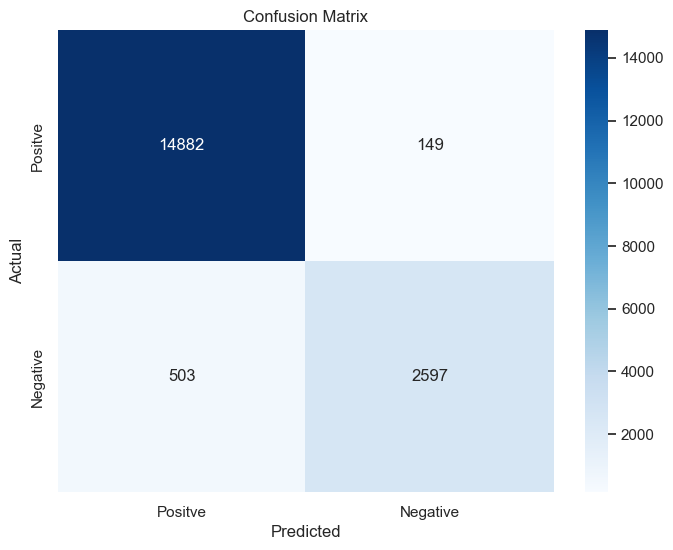

In [30]:
# [WriteCode]
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

# Make predictions on the training data
train_predictions = (model_cnn_bin.predict(seq_array) > 0.5).astype(int)

# Calculate accuracy
accuracy = (train_predictions.flatten() == label_array).mean()
print(f"Training Accuracy: {accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(label_array, train_predictions)
print("Confusion Matrix:\n", cm)

# Calculate precision and recall
precision = precision_score(label_array, train_predictions)
recall = recall_score(label_array, train_predictions)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Optional: Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positve", "Negative"], yticklabels=["Positve", "Negative"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [27]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics

- Determine the accuracy of prediction of the trained model on the test data
- Print the confusion matrix for test data prediction
- Print the precision, recall and F1 score for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

Test Accuracy: 0.6500
Confusion Matrix (Test Data):
 [[74  1]
 [ 6 19]]
Precision (Test Data): 0.9500
Recall (Test Data): 0.7600
F1 Score (Test Data): 0.8444


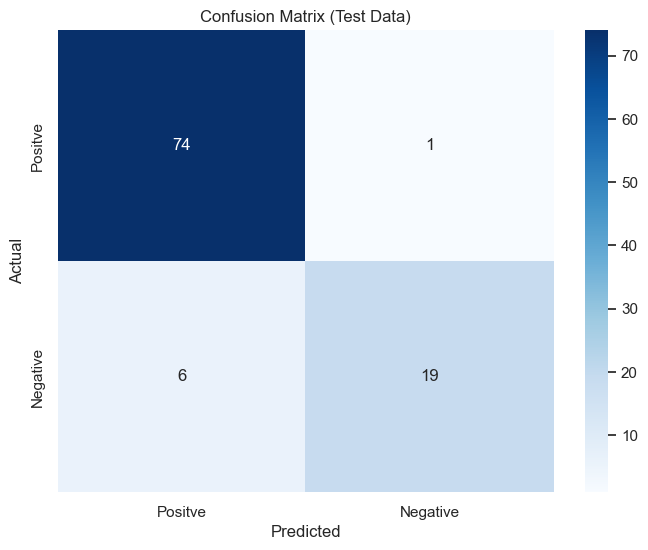

In [31]:
# [WriteCode]
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Make predictions on the test data
test_predictions = (model_cnn_bin.predict(seq_array_test_last) > 0.5).astype(int)

# Calculate accuracy
test_accuracy = (test_predictions.flatten() == label_array_test_last).mean()
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
cm_test = confusion_matrix(label_array_test_last, test_predictions)
print("Confusion Matrix (Test Data):\n", cm_test)

# Calculate precision, recall, and F1 score
test_precision = precision_score(label_array_test_last, test_predictions)
test_recall = recall_score(label_array_test_last, test_predictions)
test_f1 = f1_score(label_array_test_last, test_predictions)

print(f"Precision (Test Data): {test_precision:.4f}")
print(f"Recall (Test Data): {test_recall:.4f}")
print(f"F1 Score (Test Data): {test_f1:.4f}")

# Optional: Plot confusion matrix using seaborn for test data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Positve", "Negative"], yticklabels=["Positve", "Negative"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Test Data)')
plt.show()


#### Hyperparameter Optimisation

This involves finding the best network architecture (no. and types of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the CNN model for binary classification. 

Since a systematic search is highly computationally expensive, you will only design and implement an improved CNN model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline CNN model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved CNN model (named "model_cnn_bin_alt").
- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_bin_alt" for visualization.
- Evaluate and print training data accuracy, confusion matrix, precision and recall.
- Evaluate and print test data accuracy, confusion matrix, precision, recall and F1 score (use seq_array_test_last and label_array_test_last generated previously).

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_bin_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

### LSTM Network
In this section build a LSTM network to do binary classification. The choice of network architecture - no. of layers, type of layers, nodes per layer, activations - is left to students. Please include the following:
- name the model as "model_lstm_bin"
- dropout layer after each LSTM layer (drop probability of your choice)
- output dense layer with appropriate no. of nodes and activation for binary classification
- appropriate loss function and optimizer.

Set 'accuracy' as the metric.

Print the model summary.



In [ ]:
# [WriteCode]

#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_bin") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_bin" for visualization.

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_bin"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

#### Training data performance metrics

- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print the precision and recall for training data prediction

In [ ]:
# [WriteCode]

#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [ ]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

#### Test data performance metrics

- Determine the accuracy of prediction of the trained model on the test data
- Print the confusion matrix for test data prediction
- Print the precision, recall and F1 score for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

In [ ]:
# [WriteCode]

#### Hyperparameter Optimisation

This involves finding the best network architecture (no. and types of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the LSTM model for binary classification. 

Since a systematic search is highly computationally expensive, you will only design and implement an improved LSTM model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline LSTM model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved LSTM model (named "model_lstm_bin_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_bin_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_bin_alt" for visualization.
- Evaluate and print training data accuracy, confusion matrix, precision and recall.
- Evaluate and print test data accuracy, confusion matrix, precision, recall and F1 score (use seq_array_test_last and label_array_test_last generated previously).

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_bin_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

### Comparing CNN 1D and LSTM models for binary classification

Using a Pandas dataframe, combine the results obtained for binary classification such as accuracy, precision, recall and F1 score for test data of the CNN, LSTM, alt-CNN and alt-LSTM models for binary classification.

Display this dataframe.

In [ ]:
# [WriteCode]

## RUL Regression

### Label array generation


In [32]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels (generated from "RUL" col as it's RUL regression)
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

# final label_array which is Y target output to CNN/LSTM
print(label_array.shape)

(18131, 1)


### CNN Model

In this section, build a 1D CNN network to do RUL regression. Use the **same** CNN network architecture (no. and types of layers, no. of nodes per layer, activations) as the binary classification case. Please include the following:
- name the model as "model_cnn_rul"
- use the **same** parameter values as the baseline CNN network for binary classification
- output dense layer with appropriate no. of nodes and activation for RUL regression
- appropriate loss function and optimizer.

Set mean absolute error MAE as the metric.

Print the model summary.

In [35]:
# [WriteCode]
# Define the CNN model for RUL regression
model_cnn_rul = keras.Sequential()

# Add convolutional layers with the same architecture as binary classification
model_cnn_rul.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(sequence_cols))))
model_cnn_rul.add(keras.layers.Dropout(0.3))  # Adjust dropout rate

model_cnn_rul.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn_rul.add(keras.layers.Dropout(0.3))

model_cnn_rul.add(keras.layers.MaxPooling1D(pool_size=2))
model_cnn_rul.add(keras.layers.Flatten())

# Fully connected layer
model_cnn_rul.add(keras.layers.Dense(64, activation='relu'))
model_cnn_rul.add(keras.layers.Dropout(0.5))  # Adjust dropout rate

# Output layer for RUL regression
model_cnn_rul.add(keras.layers.Dense(1))  # No activation function for regression

# Compile the model with MAE as the metric
model_cnn_rul.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Same learning rate as before
                      loss='mean_absolute_error',  # Loss function for regression
                      metrics=['mae'])  # Set MAE as the metric

# Print the model summary
model_cnn_rul.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 23, 64)            4864      
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 21, 32)            6176      
_________________________________________________________________
dropout_11 (Dropout)         (None, 21, 32)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_rul") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_rul" for visualization.

In [39]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_rul"), histogram_freq=1, write_graph= True, update_freq='epoch')
# [WriteCode]
# # Fit the model
history_rul = model_cnn_rul.fit(
    seq_array,          # Training input data
    label_array,       # Training target output
    epochs=ep,         # Number of epochs from the parameter input
    batch_size=ba,     # Batch size from the parameter input
    validation_split=0.05,  # Use 5% of the training data for validation
    callbacks=[cb]     # Include the TensorBoard callback
)

# Print the history of the training process
print(history_rul.history)

Epoch 1/10
173/173 [==============================] - 2s 6ms/step - loss: 41.1655 - mae: 41.1655 - val_loss: 37.5711 - val_mae: 37.5711
Epoch 2/10
173/173 [==============================] - 1s 4ms/step - loss: 30.1453 - mae: 30.1453 - val_loss: 36.7433 - val_mae: 36.7433
Epoch 3/10
173/173 [==============================] - 1s 4ms/step - loss: 29.0758 - mae: 29.0758 - val_loss: 36.9778 - val_mae: 36.9778
Epoch 4/10
173/173 [==============================] - 1s 4ms/step - loss: 28.2450 - mae: 28.2450 - val_loss: 31.9057 - val_mae: 31.9057
Epoch 5/10
173/173 [==============================] - 1s 5ms/step - loss: 28.0332 - mae: 28.0332 - val_loss: 34.0431 - val_mae: 34.0431
Epoch 6/10
173/173 [==============================] - 1s 5ms/step - loss: 27.5056 - mae: 27.5056 - val_loss: 32.3351 - val_mae: 32.3351
Epoch 7/10
173/173 [==============================] - 1s 5ms/step - loss: 27.2531 - mae: 27.2531 - val_loss: 34.4780 - val_mae: 34.4780
Epoch 8/10
173/173 [============================

#### Training data performance metrics

- Print the "mean absolute error" metric for training data prediction.

In [40]:
# Make predictions on the training data
train_predictions = model_cnn_rul.predict(seq_array)

# Calculate mean absolute error (MAE) on the training data
mae_train = np.mean(np.abs(train_predictions - label_array))

# Print the MAE
print(f"Mean Absolute Error on Training Data: {mae_train:.4f}")
# [WriteCode]

Mean Absolute Error on Training Data: 31.3774


#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [41]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics
- print the "mean absolute error" metric for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

In [43]:
# [WriteCode]
# Make predictions on the test data
test_predictions = model_cnn_rul.predict(seq_array_test_last)

# Calculate mean absolute error (MAE) on the test data
mae_test = np.mean(np.abs(test_predictions - label_array_test_last))

# Print the MAE
print(f"Mean Absolute Error on Test Data: {mae_test:.4f}")



Mean Absolute Error on Test Data: 19.4297


#### Hyperparameter Optimisation

This involves finding the best network architecture (no. of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the CNN model for RUL regression.

Since a systematic search is highly computationally expensive, you will only design and implement an improved CNN model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline CNN model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved CNN model for RUL regression (named "model_cnn_rul_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_rul_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_rul_alt" for visualization.
- Evaluate and print training data MAE.
- Evaluate and print test data MAE (use seq_array_test_last and label_array_test_last generated previously).

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_rul_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

### LSTM Network

In this section, build a LSTM network to do RUL regression. Use the **same** LSTM network architecture (no. and types of layers, no. of nodes per layer, activations) as the binary classification case. Please include the following:
- name the model as "model_lstm_rul"
- use the **same** parameter values as the baseline LSTM network for binary classification
- output dense layer with appropriate no. of nodes and activation for RUL regression
- appropriate loss function and optimizer.

Set mean absolute error MAE as the metric.

Print the model summary.

In [ ]:
# [WriteCode]

#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_rul" for visualization.

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_rul"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

#### Training data performance metrics
- Print the "mean absolute error" metric for training data prediction.

In [ ]:
# [WriteCode]

#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [ ]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

#### Test data performance metrics
- print the "mean absolute error" metric for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

In [ ]:
# [WriteCode]

#### Hyperparameter Optimisation

This involves finding the best network architecture (no. of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the LSTM model for RUL regression.

Since a systematic search is highly computationally expensive, you will only design and implement an improved LSTM model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline LSTM model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved LSTM model for RUL regression (named "model_lstm_rul_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_rul_alt" for visualization.
- Evaluate and print training data MAE.
- Evaluate and print test data MAE (use seq_array_test_last and label_array_test_last generated previously).

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_rul_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

### Comparing CNN 1D and LSTM models for RUL Regression
Using a Pandas dataframe, combine the results obtained for RUL regression such as MAE for test data of the CNN, LSTM, alt-CNN and alt-LSTM models for RUL regression.

Display this dataframe.

In [ ]:
# [WriteCode]

## Visualization with TensorBoard

Many quantities such as loss function and performance metrics are saved while training the models and can be visualized using TensorBoard.

Use these visualizations to provide the evidence in your answers to the questions in Section 7.1 of the assignment document.

Make sure you select the correct information to visualize and compare. 

*Note*: Results from different runs are saved in separate time-stamped folders. 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./eec4400_logs --port=6006